In [1]:
from geoband.API import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

import os
from tqdm import tqdm

import json
import time

import warnings
warnings.filterwarnings(action='ignore')
from IPython.display import display

from tqdm import tqdm
import folium
from folium import plugins
from folium.plugins import StripePattern

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def fix_font():
    # From https://HC.Dle.pw, By Jinseo Kim
    # v1.0.0
    import os
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    os.system("apt-get install -y fonts-nanum")
    os.system("fc-cache -fv")
    mpl.font_manager._rebuild()
    findfont = mpl.font_manager.fontManager.findfont
    mpl.font_manager.findfont = findfont
    mpl.backends.backend_agg.findfont = findfont
    plt.rcParams['font.family'] = "NanumBarunGothic"
    plt.rcParams['axes.unicode_minus'] = False
           
fix_font()

## 수원시 표준 격자 기준으로 데이터 모으기

수원시 표준 격자를 기준으로 해당 격자안에 있는 데이터들을 모아보겠습니다.

In [3]:
GetCompasData('SBJ_2109_001', '32', '32.수원시_표준격자(250M_x_250M).geojson')
suwon_grid = gpd.read_file('32.수원시_표준격자(250M_x_250M).geojson')
suwon_grid.head()

,gid,geometry
0,다사49aa19ab,"MULTIPOLYGON (((126.92477 37.27077, 126.92475 ..."
1,다사49aa19ba,"MULTIPOLYGON (((126.92475 37.27302, 126.92473 ..."
2,다사49aa20aa,"MULTIPOLYGON (((126.92472 37.27753, 126.92470 ..."
3,다사49ab18ab,"MULTIPOLYGON (((126.92766 37.26177, 126.92764 ..."
4,다사49ab18ba,"MULTIPOLYGON (((126.92764 37.26402, 126.92762 ..."


### 격자 별 공원 수

In [4]:
GetCompasData('SBJ_2109_001', '27', '27.4개시도_공원현황.csv')
park_df = pd.read_csv('27.4개시도_공원현황.csv')

In [5]:
suwon_grid["park_cnt"] = 0

In [6]:
from shapely.geometry import Point, Polygon, LineString
for park_idx, park_row in tqdm(park_df.iterrows()): #위치 좌표 데이터
    for grid_idx, grid_row in suwon_grid.iterrows(): #수원 표준격자 데이터
        grid = grid_row["geometry"]
        po = Point([park_row['lon'], park_row['lat']])
        if po.within(grid) == True:
            suwon_grid["park_cnt"][grid_idx] += 1

### 격자별 파출소 수 (신고 수 기준)
수원시 신고이력을 토대로 파출소를 셌기 때문에, 해당 격자에 출동을 한 파출소를 세는 것에 해당합니다.

In [7]:
GetCompasData('SBJ_2109_001', '1', '1.수원시_112신고이력(격자_관할경계매핑).csv')
suwon_grid_report = pd.read_csv('1.수원시_112신고이력(격자_관할경계매핑).csv')

In [8]:
temp_df = pd.pivot_table(suwon_grid_report,
               index='gid',
               columns='name',
               values='arrival_date',
               aggfunc='count'
               )


In [9]:
temp_count_df = temp_df.T.notnull().sum()
temp_count_df = temp_count_df.to_frame()
temp_count_df.rename(columns={0: 'patrol_cnt'}, inplace=True)

In [11]:
temp_count_df = temp_count_df.reset_index()

In [13]:
suwon_grid = pd.merge(suwon_grid, temp_count_df, on='gid', how='left')
suwon_grid.fillna(0, inplace=True)

### 격자별 비상벨 수

In [14]:
GetCompasData('SBJ_2109_001', '23', '23.4개시도_안전비상벨현황.geojson')
bell_df = gpd.read_file('23.4개시도_안전비상벨현황.geojson')

In [15]:
suwon_grid["bell_cnt"] = 0

In [16]:
for bell_idx, bell_row in tqdm(bell_df.iterrows()): #위치 좌표 데이터
    for grid_idx, grid_row in suwon_grid.iterrows(): #수원 표준격자 데이터
        grid = grid_row["geometry"]
        po = bell_row["geometry"]
        if po.within(grid) == True:
            suwon_grid["bell_cnt"][grid_idx] += 1

### 격자별 여성안심택배함 수

In [17]:
GetCompasData('SBJ_2109_001', '20', '20.수원시_여성안심택배함현황.csv')
women_parcel_df = pd.read_csv('20.수원시_여성안심택배함현황.csv')

In [18]:
suwon_grid['womenpost_cnt'] = 0

In [19]:
for post_idx, post_row in tqdm(women_parcel_df.iterrows()): #위치 좌표 데이터
    for grid_idx, grid_row in suwon_grid.iterrows(): #수원 표준격자 데이터
        grid = post_row["geometry"]
        po = bell_row["geometry"]
        if po.within(grid) == True:
            suwon_grid["womenpost_cnt"][grid_idx] += 1

### 격자별 CCTV 수

In [20]:
GetCompasData('SBJ_2109_001', '24', '24.4개시도_CCTV설치현황.csv')
df_cctv = pd.read_csv('24.4개시도_CCTV설치현황.csv')

In [21]:
df_cctv.dropna(subset=['address'], inplace=True)
df_cctv['address'].isnull().sum()

In [ ]:
df_cctv_suwon = df_cctv[df_cctv['address'].str.startswith('경기') | df_cctv['address'].str.startswith('수원') 
                        | df_cctv['address'].str.startswith('팔달') | df_cctv['address'].str.startswith('권선')
                        | df_cctv['address'].str.startswith('장안') | df_cctv['address'].str.startswith('영통')]

In [ ]:
df_cctv.reindex(index=list(range(34525, 38363)))
df_cctv_suwon.reset_index(drop=True, inplace=True)

In [ ]:
from shapely.geometry import Point, Polygon, LineString
points = []
for i in range(0, len(df_cctv_suwon)):
    point = Point(df_cctv_suwon['lon'][i], df_cctv_suwon['lat'][i])
    points.append(point)
    
df_cctv_suwon['geometry'] = points

In [ ]:
suwon_grid['cctv_cnt'] = 0

In [ ]:
for i in range(0, len(df_cctv_suwon)):
    for j in range(0, len(suwon_grid)):
        if df_cctv_suwon['geometry'][i].within(suwon_grid['geometry'][j]):
            suwon_grid['cctv_cnt'][j] = suwon_grid['cctv_cnt'][j] + df_cctv_suwon['cctv_cnt'][i]

### 격자별 보안등 수

In [ ]:
GetCompasData('SBJ_2109_001', '22', '22.4개시도_보안등현황.csv')
df_sec_light = pd.read_csv('22.4개시도_보안등현황.csv')

In [ ]:
df_sec_light['address'].isnull().sum()
df_sec_light.dropna(subset=['address'], inplace=True)
df_sec_light['address'].isnull().sum()

In [ ]:
df_sec_light[df_sec_light['address'].str.startswith('경기')]

In [ ]:
df_sec_light_suwon = df_sec_light.reindex(index = list(range(171483, 185403 + 1)))

In [ ]:
df_sec_light_suwon[df_sec_light_suwon['address'].isnull()]

In [ ]:
df_sec_light_suwon.reset_index(drop=True, inplace=True)

In [ ]:
from shapely.geometry import Point, Polygon, LineString
points_sec = []
for i in range(0, len(df_sec_light_suwon)):
    point = Point(df_sec_light_suwon['lon'][i], df_sec_light_suwon['lat'][i])
    points_sec.append(point)

In [ ]:
df_sec_light_suwon['geometry'] = points_sec

In [ ]:
suwon_grid['securitylight_cnt'] = 0

In [ ]:
for i in range(0, len(df_sec_light_suwon)):
    for j in range(0, len(suwon_grid)):
        if df_sec_light_suwon['geometry'][i].within(suwon_grid['geometry'][j]):
            suwon_grid['securitylight_cnt'][j] = suwon_grid['securitylight_cnt'][j] + df_sec_light_suwon['securitylight_cnt'][i]

### 격자별 가로등 수

In [ ]:
GetCompasData('SBJ_2109_001', '21', '21.수원시_가로등현황.csv')
df_street_light = pd.read_csv('21.수원시_가로등현황.csv')

In [ ]:
from shapely.geometry import Point, Polygon, LineString
points_st = []
for i in range(0, len(df_street_light)):
    point = Point(df_street_light['lon'][i], df_street_light['lat'][i])
    points_st.append(point)

In [ ]:
df_street_light['geometry'] = points_st

In [ ]:
suwon_grid['streetlight_cnt'] = 0

In [ ]:
for i in tqdm(range(0, len(df_street_light))):
    for j in range(0, len(suwon_grid)):
        if df_street_light['geometry'][i].within(df_gid['geometry'][j]):
            suwon_grid['streetlight_cnt'][j] = suwon_grid['streetlight_cnt'][j] + df_street_light['streetlight_cnt'][i]

### 격자별 신고수

In [ ]:
GetCompasData('SBJ_2109_001', '2', '2.수원시_112신고(격자별 신고횟수).geojson')
report_cnt = gpd.read_file('2.수원시_112신고(격자별 신고횟수).geojson')

In [ ]:
suwon_grid = pd.merge(suwon_grid, report_cnt, on='gid')

### 격자별 인구수

In [ ]:
GetCompasData('SBJ_2109_001', '30', '30.수원시_성연령별_거주인구격자(250M_X_250M).geojson')
grid_pop = gpd.read_file('30.수원시_성연령별_거주인구격자(250M_X_250M).geojson')

In [ ]:
grid_pop.fillna(0, inplace=True)

In [ ]:
grid_pop['total_pop'] = grid_pop.sum(axis=1)

In [ ]:
suwon_grid = pd.merge(suwon_grid, grid_pop, on='gid')

최종적으로 데이터를 모아서 grid_data라는 변수명에 지정해줬습니다.

In [23]:
grid_data = suwon_grid.copy()

___

### 시각화

In [22]:
def fix_font():
    # From https://HC.Dle.pw, By Jinseo Kim
    # v1.0.0
    import os
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    os.system("apt-get install -y fonts-nanum")
    os.system("fc-cache -fv")
    mpl.font_manager._rebuild()
    findfont = mpl.font_manager.fontManager.findfont
    mpl.font_manager.findfont = findfont
    mpl.backends.backend_agg.findfont = findfont
    plt.rcParams['font.family'] = "NanumBarunGothic"
    plt.rcParams['axes.unicode_minus'] = False
           
fix_font()

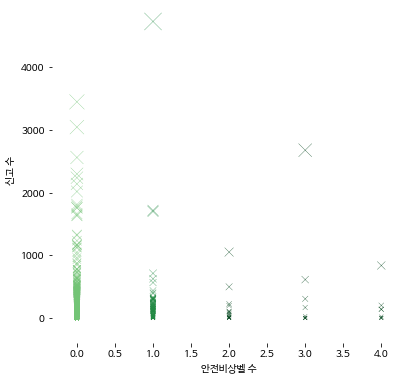

In [24]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=grid_data, y='rep_cnt', x='bell_cnt', marker='x',
                hue='bell_cnt', hue_norm=(-2, 2), palette="Greens",
                size='rep_cnt', sizes=(15, 300),
                ax=ax)
ax.set_ylabel('신고 수')
ax.set_xlabel('안전비상벨 수')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_position(("outward", 10))
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["bottom"].set_position(("outward", 10))

handle, label = ax.get_legend_handles_labels()
new_label = ['안전비상벨 수', '0', '1', '2', '3', '4', '신고 수', '0', '800', '1600', '2400', '3200', '4000']
ax.get_legend().remove()



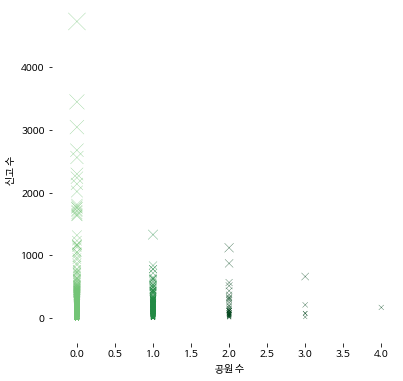

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=grid_data, y='rep_cnt', x='park_cnt', marker='x',
                hue='park_cnt', hue_norm=(-2, 2), palette="Greens",
                size='rep_cnt', sizes=(15, 300),
                ax=ax)
ax.set_ylabel('신고 수')
ax.set_xlabel('공원 수')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_position(("outward", 10))
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["bottom"].set_position(("outward", 10))

handle, label = ax.get_legend_handles_labels()
new_label = ['공원 수', '0', '1', '2', '3', '4', '신고 수', '0', '800', '1600', '2400', '3200', '4000']
ax.get_legend().remove()



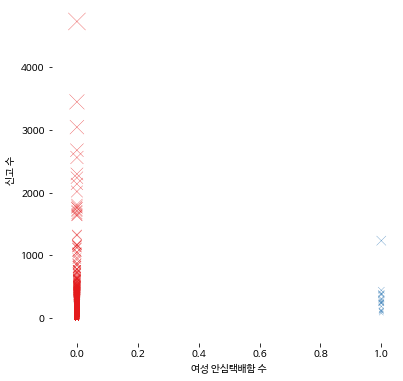

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=grid_data, y='rep_cnt', x='womanpost_cnt', marker='x',
                hue='womanpost_cnt', palette="Set1",
                size='rep_cnt', sizes=(15, 300),
                ax=ax)
ax.set_ylabel('신고 수')
ax.set_xlabel('여성 안심택배함 수')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_position(("outward", 10))
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["bottom"].set_position(("outward", 10))

handle, label = ax.get_legend_handles_labels()
new_label = ['여성 안심택배함 수', '0', '1', '신고 수', '0', '800', '1600', '2400', '3200', '4000']
ax.get_legend().remove()



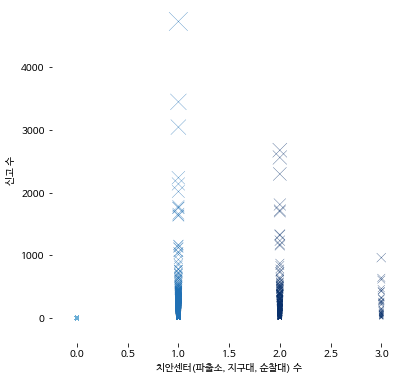

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=grid_data, y='rep_cnt', x='patrol_cnt', marker='x',
                hue='patrol_cnt', hue_norm=(-2, 2), palette="Blues",
                size='rep_cnt', sizes=(15, 350),
                ax=ax)
ax.set_ylabel('신고 수')
ax.set_xlabel('치안센터(파출소, 지구대, 순찰대) 수')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_position(("outward", 10))
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["bottom"].set_position(("outward", 10))

handle, label = ax.get_legend_handles_labels()
new_label = ['치안센터(파출소, 지구대, 순찰대) 수', '0', '1', '2', '3', '4', '신고 수', '0', '800', '1600', '2400', '3200', '4000']
ax.get_legend().remove()



### CCTV, 가로등, 보안등 수 - 카테고리화
CCTV, 가로등, 보안등 수는 갯수가 많아 카테고리화 해서 산점도를 그려보겠습니다.

In [29]:
df_cctv = grid_data[['gid','cctv_cnt', 'rep_cnt']]
df_streetlight = grid_data[['gid', 'streetlight_cnt', 'rep_cnt']]
df_securitylight = grid_data[['gid', 'securitylight_cnt', 'rep_cnt']]

In [30]:
df_cctv['cctv_category'] = pd.cut(df_cctv['cctv_cnt'], 5, duplicates='drop', labels=False)
df_securitylight['sec_category'] = pd.cut(df_securitylight['securitylight_cnt'], 5, duplicates='drop', labels=False)
df_streetlight['st_category'] = pd.cut(df_streetlight['streetlight_cnt'], 5, duplicates='drop', labels=False)

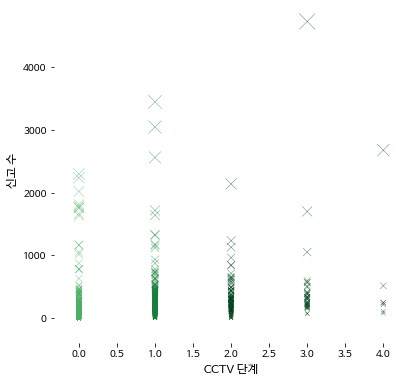

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df_cctv, y='rep_cnt', x='cctv_category', marker='x',
                hue='cctv_category', hue_norm=(-3, 2), palette="Greens",
                size='rep_cnt', sizes=(15, 250),
                ax=ax)
ax.set_ylabel('신고 수', fontsize=12)
ax.set_xlabel('CCTV 단계', fontsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_position(("outward", 10))
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["bottom"].set_position(("outward", 10))

ax.get_legend().remove()

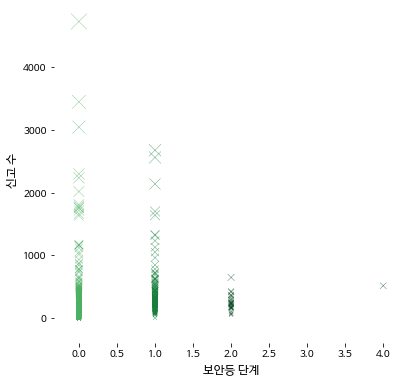

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df_securitylight, y='rep_cnt', x='sec_category', marker='x',
                hue='sec_category', hue_norm=(-3, 2), palette="Greens",
                size='rep_cnt', sizes=(15, 250),
                ax=ax)
ax.set_ylabel('신고 수', fontsize=12)
ax.set_xlabel('보안등 단계', fontsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_position(("outward", 10))
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["bottom"].set_position(("outward", 10))

ax.get_legend().remove()



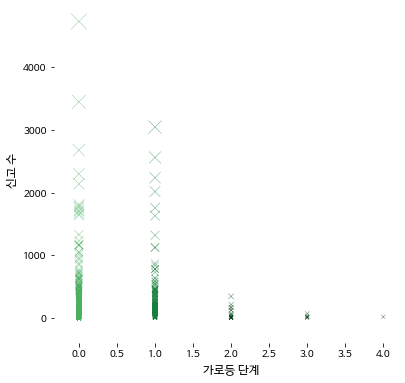

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=df_streetlight, y='rep_cnt', x='st_category', marker='x',
                hue='st_category', hue_norm=(-3, 2), palette="Greens",
                size='rep_cnt', sizes=(15, 250),
                ax=ax)
ax.set_ylabel('신고 수', fontsize=12)
ax.set_xlabel('가로등 단계', fontsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_position(("outward", 10))
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["bottom"].set_position(("outward", 10))

ax.get_legend().remove()

plt.savefig('streetlight_sample.png', transparent=True)
